In [98]:
from ucimlrepo import fetch_ucirepo 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

In [99]:
bank_marketing = fetch_ucirepo(id=222) 

## Dataset Overview

- **Số dòng:** 45,211  
- **Số cột:** 17  
- **Kiểu dữ liệu:**  
  - 7 biến số (int64)  
  - 10 biến phân loại (object)  
Dataset mô tả thông tin khách hàng và các chiến dịch marketing trực tiếp của ngân hàng, với mục tiêu dự đoán khả năng khách hàng đăng ký tiền gửi có kỳ hạn (term deposit).

---

## Variable Description

| Tên biến | Kiểu dữ liệu | Mô tả |
|--------|-------------|------|
| **age** | int | Tuổi của khách hàng. |
| **job** | categorical | Nghề nghiệp của khách hàng (ví dụ: management, technician, blue-collar, student, …). Có một số giá trị thiếu. |
| **marital** | categorical | Tình trạng hôn nhân của khách hàng (married, single, divorced). |
| **education** | categorical | Trình độ học vấn của khách hàng (primary, secondary, tertiary). Một số giá trị bị thiếu. |
| **default** | categorical | Khách hàng có bị vỡ nợ tín dụng hay không (yes/no). |
| **balance** | int | Số dư tài khoản trung bình hàng năm (đơn vị tiền tệ địa phương). |
| **housing** | categorical | Khách hàng có khoản vay mua nhà hay không (yes/no). |
| **loan** | categorical | Khách hàng có khoản vay cá nhân hay không (yes/no). |
| **contact** | categorical | Phương thức liên hệ trong chiến dịch marketing (cellular, telephone). Có giá trị thiếu. |
| **day_of_week** | int | Ngày trong tháng khi khách hàng được liên hệ. |
| **month** | categorical | Tháng khách hàng được liên hệ trong chiến dịch marketing. |
| **duration** | int | Thời lượng cuộc gọi (tính bằng giây). *Lưu ý: biến này chỉ biết sau khi cuộc gọi kết thúc và có nguy cơ gây data leakage nếu dùng để dự đoán trước khi gọi.* |
| **campaign** | int | Số lần liên hệ với khách hàng trong chiến dịch hiện tại. |
| **pdays** | int | Số ngày kể từ lần liên hệ trước đó trong chiến dịch trước. Giá trị đặc biệt (ví dụ: 999) thể hiện khách hàng chưa từng được liên hệ. |
| **previous** | int | Số lần khách hàng được liên hệ trong các chiến dịch marketing trước đó. |
| **poutcome** | categorical | Kết quả của chiến dịch marketing trước (success, failure, other). Giá trị thiếu thể hiện khách hàng chưa từng tham gia chiến dịch trước. |
| **y** | categorical | Biến mục tiêu: khách hàng có đăng ký tiền gửi có kỳ hạn hay không (yes/no). |



In [100]:
df = bank_marketing.data.original
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [101]:
eda_notes = {
    "job": "Có nhiều nhóm hiếm, cân nhắc gộp khi encoding",
    "default": "Biến gần như hằng, cân nhắc loại bỏ khi modeling",
    "month": "Phân phối lệch do chiến dịch theo mùa",
    "poutcome": "Missing mang ý nghĩa nghiệp vụ (no previous campaign)",
    "duration": "Gây leakage, không dùng cho dự đoán trước khi gọi"
}

In [102]:
print("Shape:", df.shape)
df.info()

Shape: (45211, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### 3) Làm sạch cơ bản và kiểm tra giá trị null

In [103]:
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


**Missing Values Analysis:**  
- Các giá trị thiếu chủ yếu xuất hiện ở các biến phân loại như `poutcome`, `contact`, `education` và `job`.  
- Không có giá trị thiếu ở các biến số và biến mục tiêu (`y`).  
- Điều này cho thấy missing values không phải do lỗi dữ liệu ngẫu nhiên mà nhiều khả năng phản ánh các trường hợp thông tin nghiệp vụ không tồn tại (ví dụ: khách hàng chưa từng tham gia chiến dịch trước đó).

ví dụ :
poutcome chỉ có ý nghĩa khi previous > 0 hoặc khách đã từng được contact trong các campaign trước.

Nếu khách hàng là new / first-time contact, thì poutcome “thiếu” chính là tín hiệu:
khách hàng chưa từng tham gia campaign trước.

In [104]:
missing_df = df.isna().sum().sort_values(ascending=False).reset_index()
missing_df.columns = ["feature", "missing_count"]
missing_df[missing_df["missing_count"]>0]

,feature,missing_count
0,poutcome,36959
1,contact,13020
2,education,1857
3,job,288


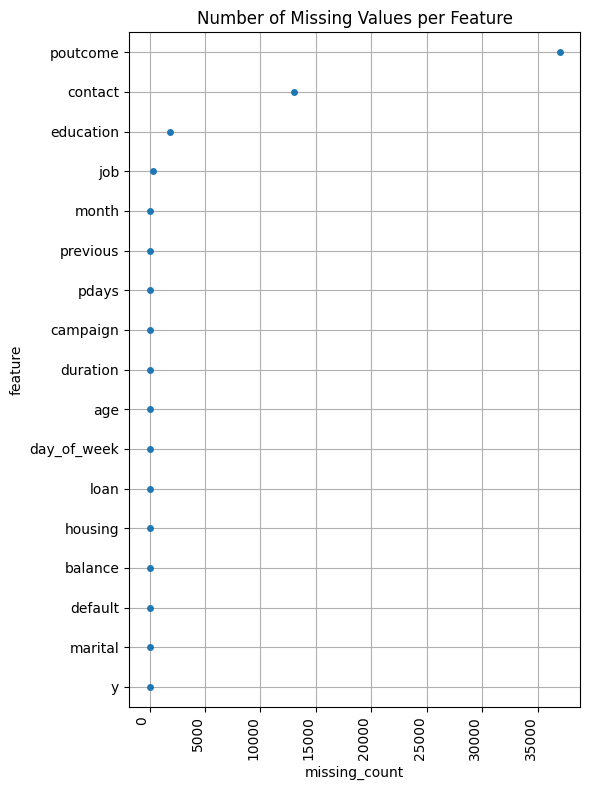

In [105]:
plt.figure(figsize=(6, 8))
sns.stripplot(
    y="feature",
    x="missing_count",
    data=missing_df
)
plt.title("Number of Missing Values per Feature")
plt.xticks(rotation=90, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()


Kiểm tra giá trị unique của các cột có missing: missing xuất hiện ở các biến phân loại, và là NaN thật

In [106]:
for col in ["poutcome", "contact", "education", "job"]:
    print(col, df[col].unique())

poutcome [nan 'failure' 'other' 'success']
contact [nan 'cellular' 'telephone']
education ['tertiary' 'secondary' nan 'primary']
job ['management' 'technician' 'entrepreneur' 'blue-collar' nan 'retired'
 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid' 'student']


Kiểm tra logic nghiệp vụ giữa previous, pdays, poutcome:  Nếu chưa từng có campaign trước → không thể có kết quả campaign trước (previous = 0 --> poutcome = NaN)

In [107]:
df[["previous","pdays","poutcome","y"]].head()

,previous,pdays,poutcome,y
0,0,-1,NaN,no
1,0,-1,NaN,no
2,0,-1,NaN,no
3,0,-1,NaN,no
4,0,-1,NaN,no


Tạo biến đánh dấu missing của poutcome/ dùng để phân tích

In [108]:
df["poutcome_missing"] = df["poutcome"].isna().astype(int)

Kiểm tra mối liên hệ giữa missing và previous:

In [109]:
pd.crosstab(df["poutcome_missing"], df["previous"] > 0, normalize="index")

previous,False,True
poutcome_missing,,
0,0.000000,1.000000
1,0.999865,0.000135


So sánh tỷ lệ đăng ký giữa nhóm missing vs non-missing: Missing ảnh hưởng rõ rệt đến target 

In [110]:
df["target"] = (df["y"] == "yes").astype(int)
df.groupby(df["poutcome"].isna())["target"].mean()

poutcome
False    0.230611
True     0.091615
Name: target, dtype: float64

**EDA on Missing Values (Business Meaning):**  
- Các giá trị thiếu ở biến `poutcome` xuất hiện khi khách hàng chưa từng tham gia chiến dịch marketing trước đó (`previous = 0`, `pdays = -1`).  
- Missing values này không xuất hiện ngẫu nhiên mà phản ánh cấu trúc nghiệp vụ của dữ liệu.  
- Phân tích cho thấy nhóm khách hàng có `poutcome` không bị thiếu có tỷ lệ đăng ký cao hơn đáng kể so với nhóm bị thiếu.  
- Do đó, các giá trị thiếu ở `poutcome` mang ý nghĩa thông tin và được ghi nhận để xử lý ở bước preprocessing sau.


Xử lý sơ giá trj

In [111]:
df["poutcome"] = df["poutcome"].fillna("no_previous_campaign")
df["pdays_contacted"] = (df["pdays"] != -1).astype(int)
df["has_previous_campaign"] = (df["previous"] > 0).astype(int)

In [112]:
df["target"] = (df["y"] == "yes").astype(int)

df.groupby("poutcome")["target"].mean().sort_values(ascending=False)


poutcome
success                 0.647253
other                   0.166848
failure                 0.126097
no_previous_campaign    0.091615
Name: target, dtype: float64

**Handling Missing Values with Business Context:**  
- Các giá trị thiếu ở biến `poutcome` được gán nhãn là `no_previous_campaign`, phản ánh trường hợp khách hàng chưa từng tham gia chiến dịch marketing trước đó.  
- Cách xử lý này dựa trên phân tích EDA cho thấy missing values ở `poutcome` có mối liên hệ chặt chẽ với `previous = 0` và `pdays = -1`.  
- Kết quả sau khi xử lý cho thấy tỷ lệ đăng ký thay đổi hợp lý theo từng nhóm `poutcome`, xác nhận rằng việc xử lý missing giữ được ý nghĩa nghiệp vụ của dữ liệu.



**Target Distribution Analysis:**  
- Biến mục tiêu `y` có phân phối không cân bằng, với khoảng 88% khách hàng không đăng ký và chỉ khoảng 12% khách hàng đăng ký term deposit.  
- Đây là đặc điểm phổ biến trong các bài toán marketing ngân hàng và phản ánh thực tế nghiệp vụ.  
- Do đó, hiện tượng mất cân bằng lớp được ghi nhận trong giai đoạn EDA để làm cơ sở cho việc lựa chọn phương pháp đánh giá và xử lý phù hợp ở các bước modeling tiếp theo.


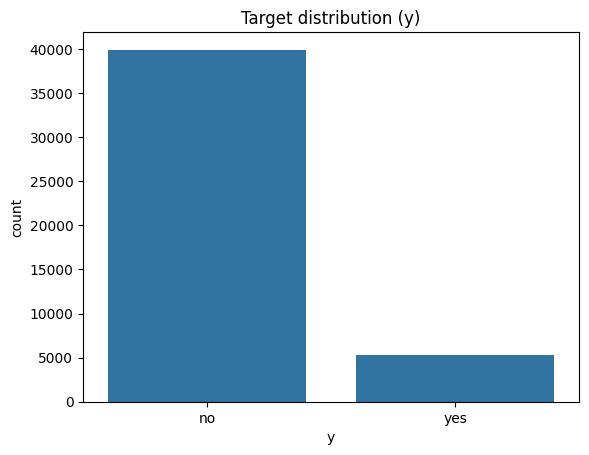

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

In [113]:
sns.countplot(x="y", data=df)
plt.title("Target distribution (y)")
plt.show()
df["y"].value_counts(normalize=True)

In [114]:
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day_of_week,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


**Numerical Feature Distribution Analysis:**  
- Các biến số trong dữ liệu có phân phối không đối xứng và nhiều đuôi dài, phản ánh hành vi thực tế của khách hàng trong bối cảnh ngân hàng.  
- Một số biến như `balance`, `duration`, `campaign` và `previous` có nhiều giá trị cực đoan, tuy nhiên đây không phải lỗi dữ liệu mà là đặc điểm tự nhiên của dữ liệu hành vi.  
- Ngoài ra, các biến như `pdays` và `previous` mang tính mã nghiệp vụ hơn là biến số thuần túy.  
- Những đặc điểm này được ghi nhận trong giai đoạn EDA để làm cơ sở cho các bước xử lý và mô hình hóa tiếp theo.


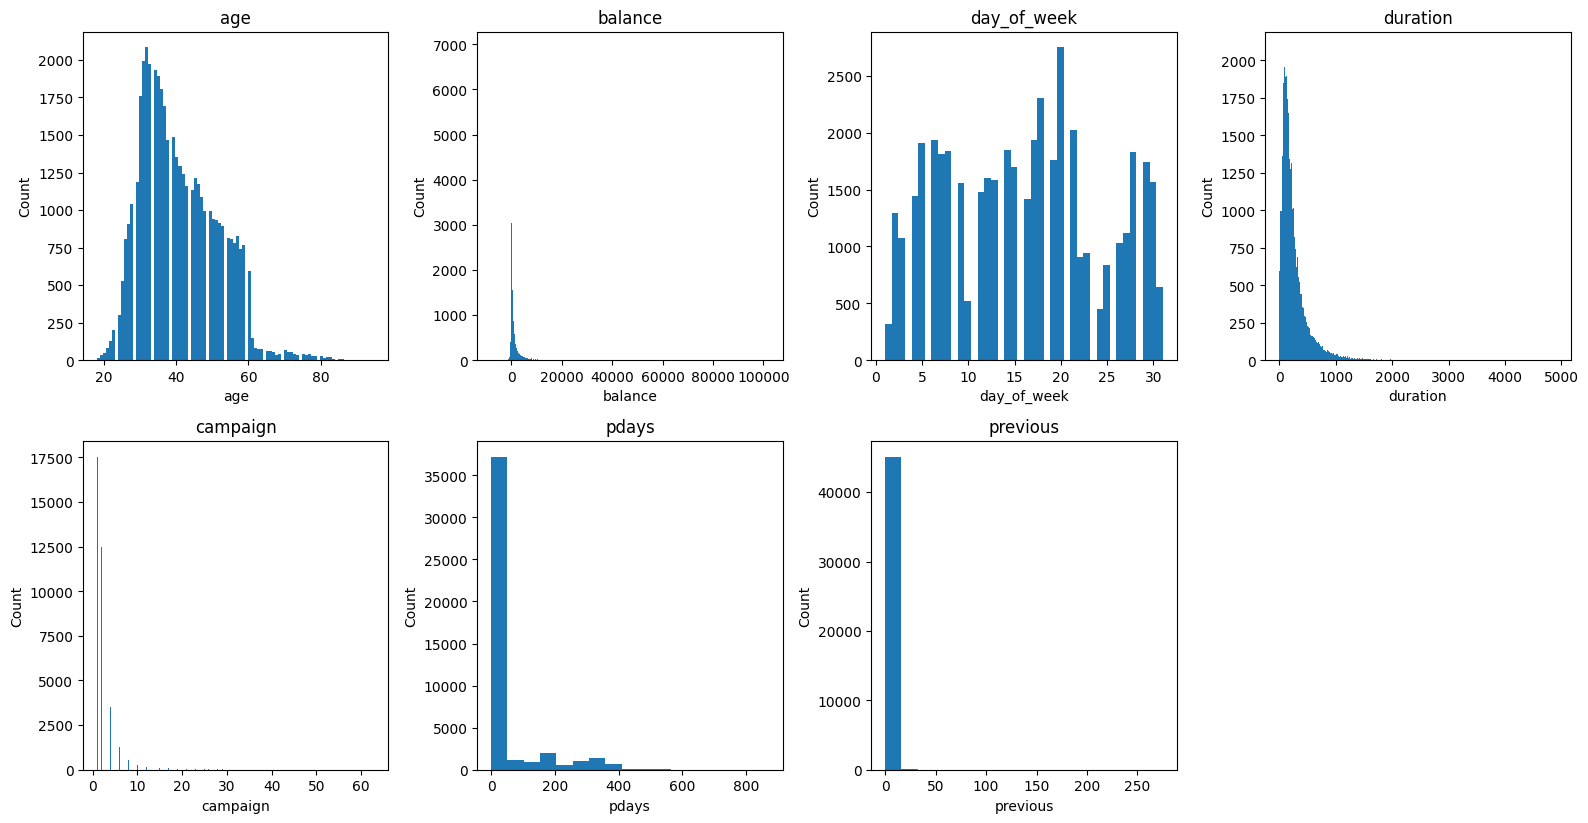

In [115]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    plt.hist(df[col], bins="auto")
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


**Outlier Analysis:**  
- Nhiều biến số trong dữ liệu xuất hiện các giá trị bị coi là outlier theo tiêu chí thống kê (IQR).  
- Tuy nhiên, các outlier này phản ánh hành vi thực tế của khách hàng ngân hàng (ví dụ: số dư lớn, thời lượng cuộc gọi dài, số lần liên hệ nhiều) và không phải là lỗi dữ liệu 

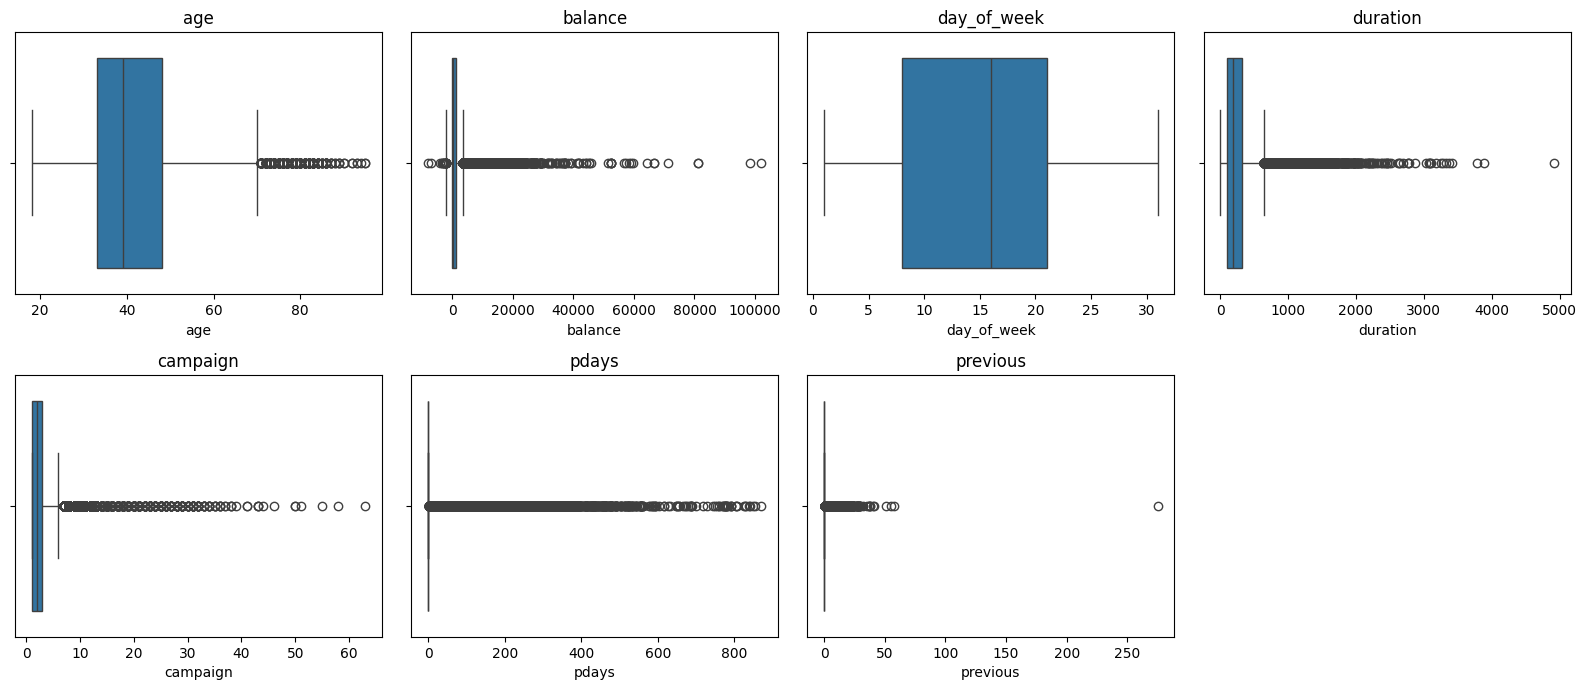

In [116]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

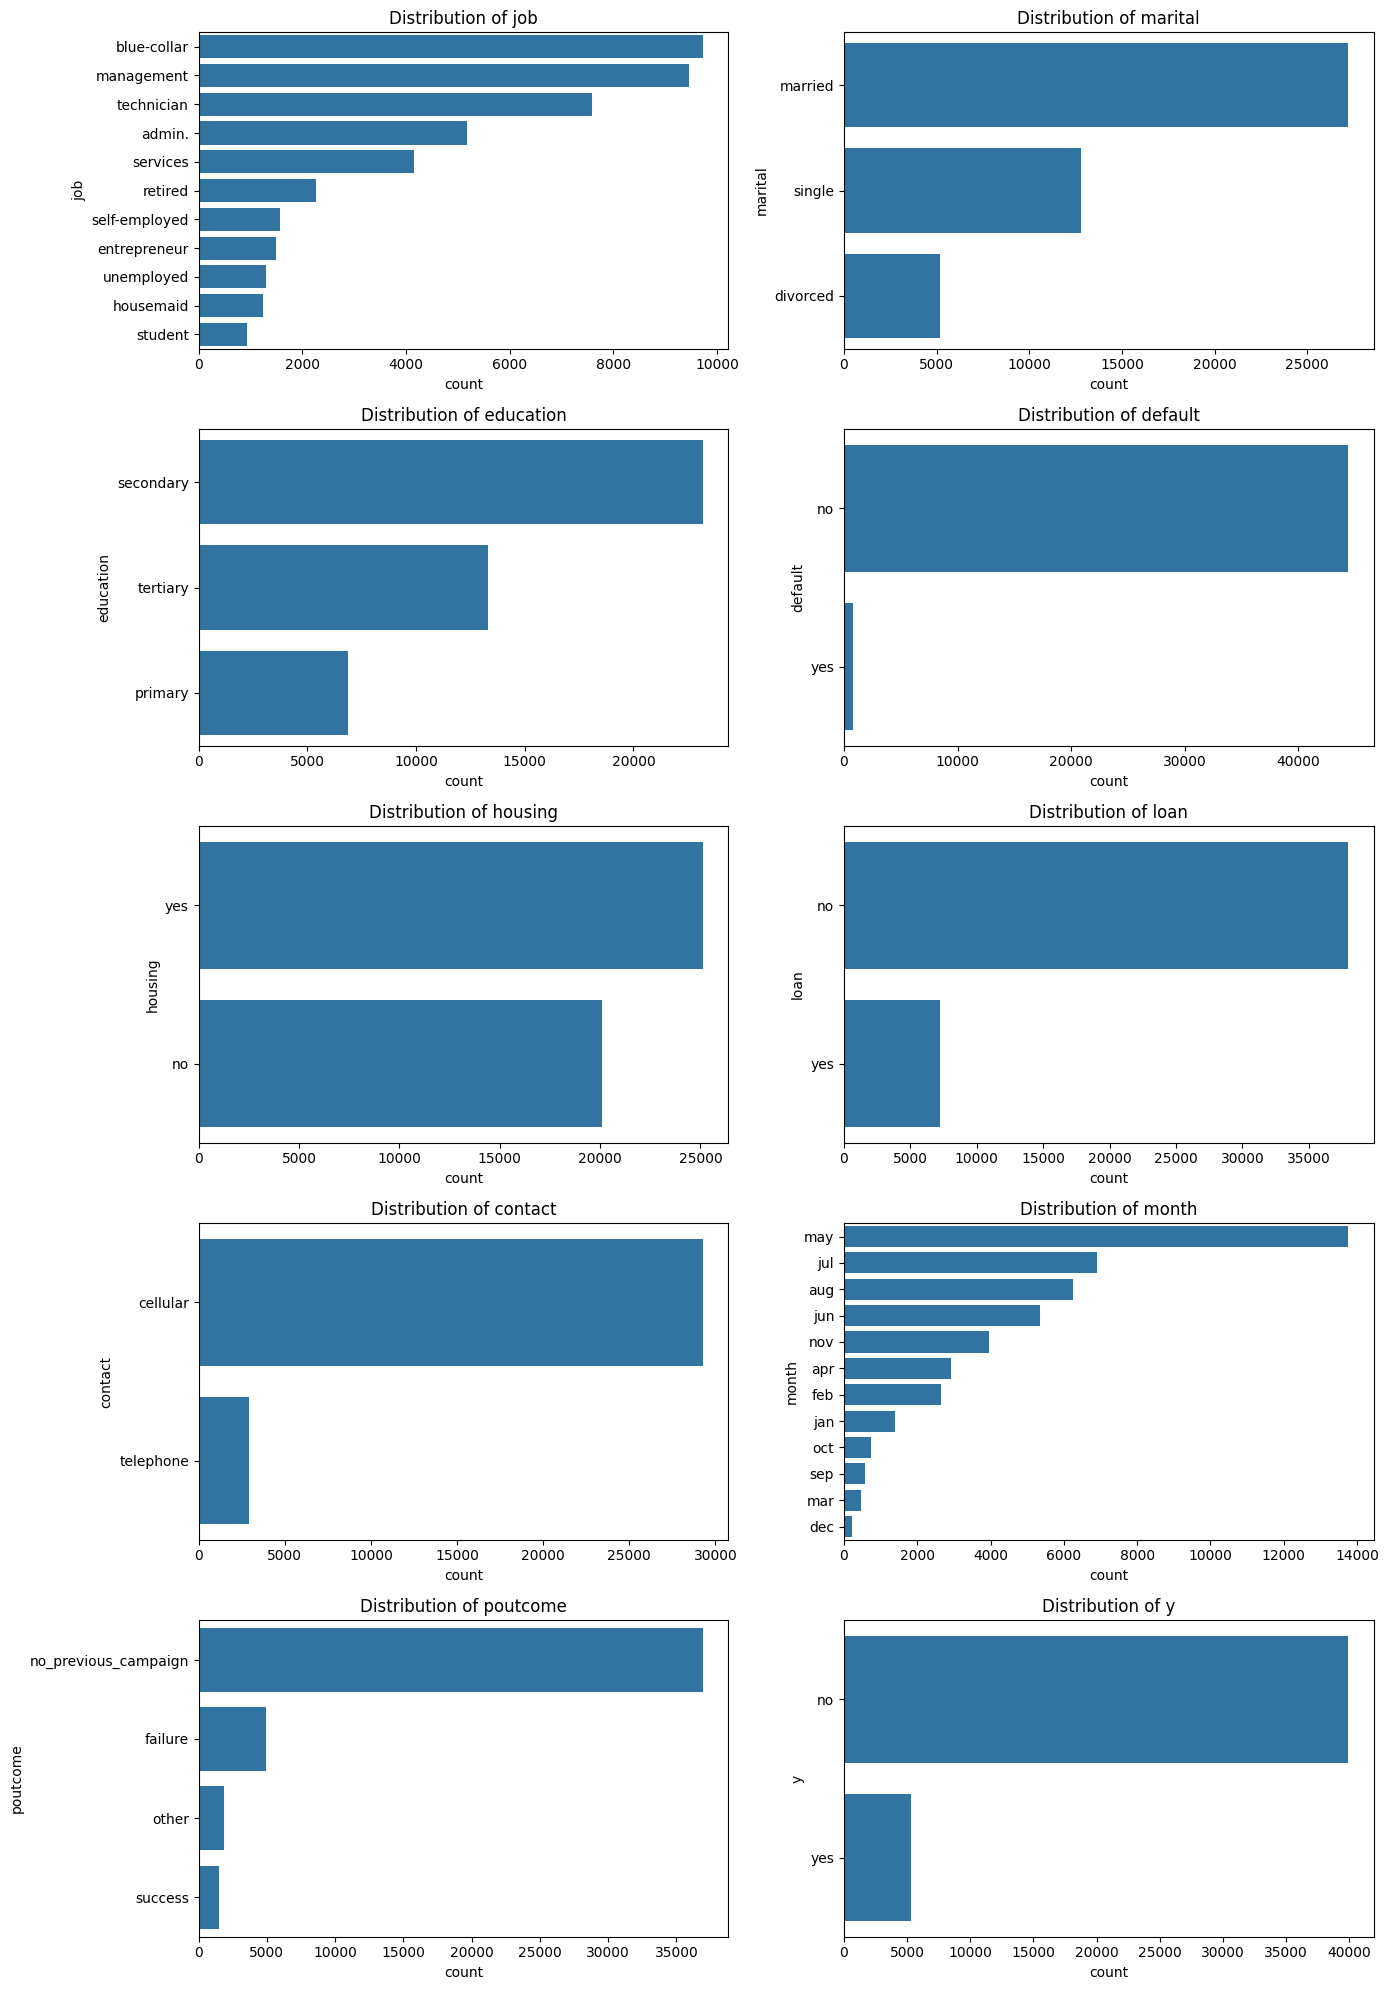

In [117]:
n_cols = 2
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(14, 4 * n_rows)
)

axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    sns.countplot(
        y=col,
        data=df,
        order=df[col].value_counts().index,
        ax=ax
    )
    ax.set_title(f"Distribution of {col}")

for i in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


**Categorical Features vs Target:**  
- Biểu đồ cho thấy tỷ lệ đăng ký khác nhau rõ rệt giữa các nhóm của các biến phân loại như `job`, `education`, `contact` và `poutcome`.  
- Các biến phân loại mang thông tin quan trọng liên quan đến hành vi đăng ký của khách hàng và có tiềm năng đóng góp vào mô hình dự đoán.


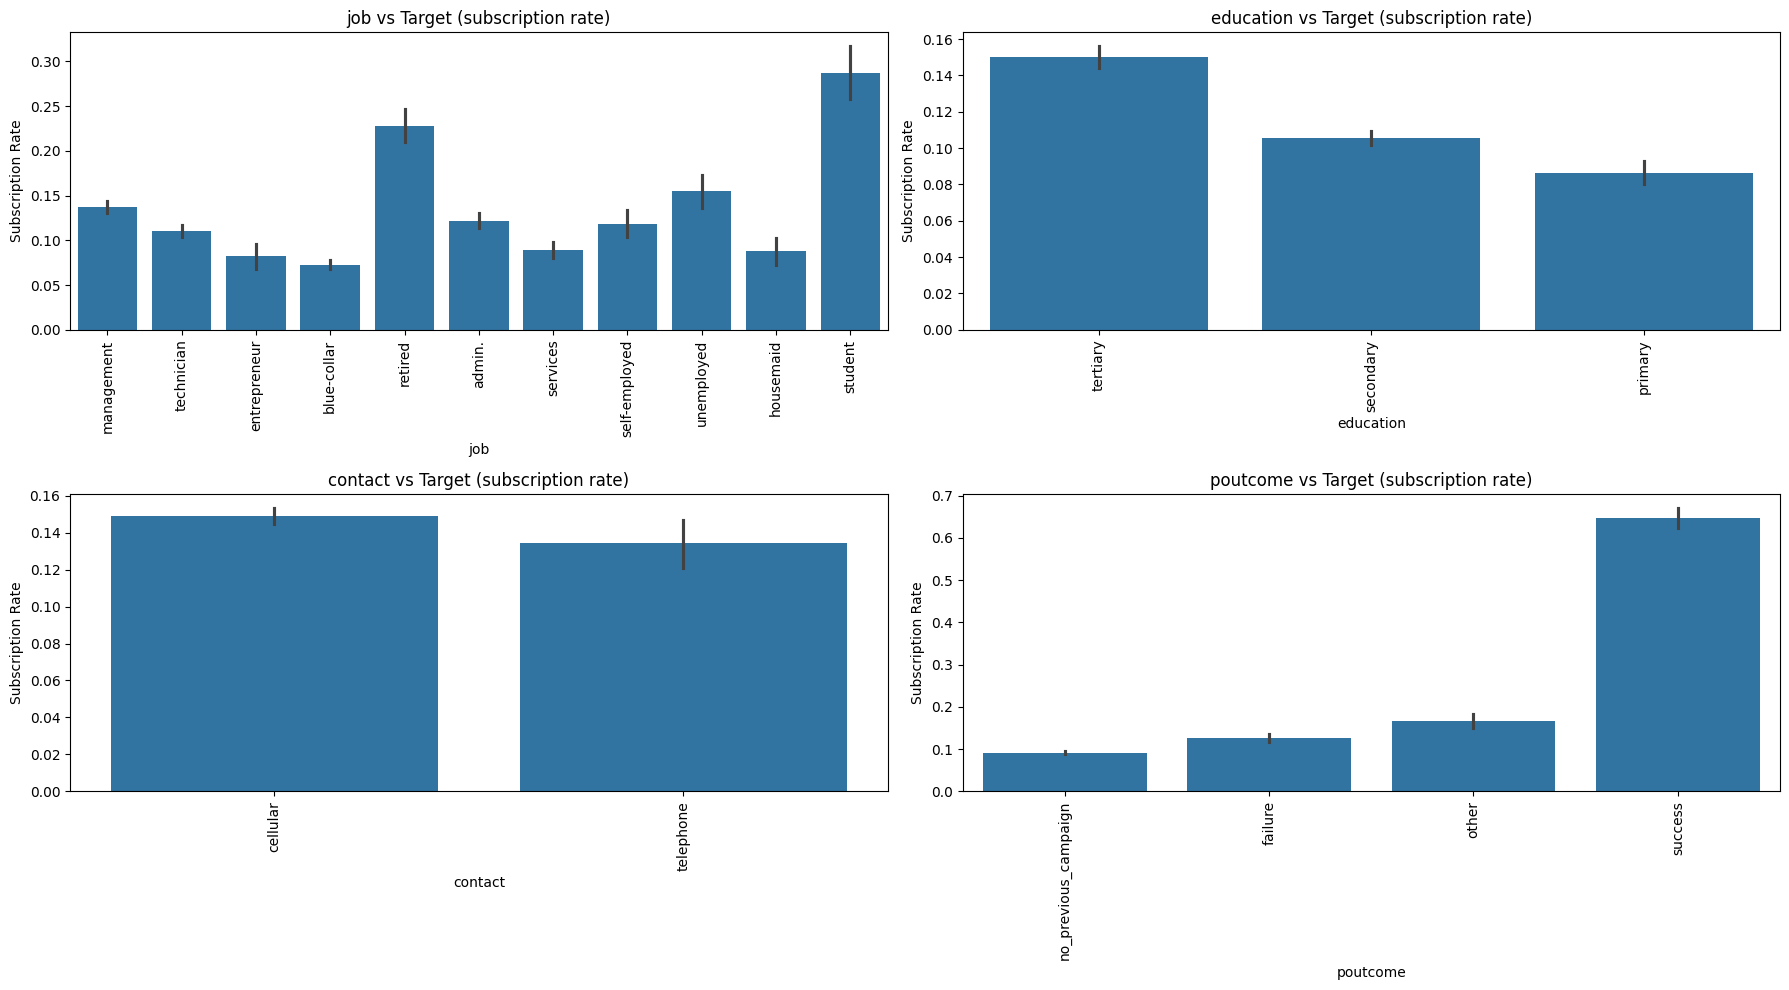

In [118]:
cols = ["job", "education", "contact", "poutcome"]

fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(18, 10)
)

axes = axes.flatten()

for ax, col in zip(axes, cols):
    sns.barplot(
        x=col,
        y=(df["y"] == "yes").astype(int),
        data=df,
        ax=ax
    )
    ax.set_title(f"{col} vs Target (subscription rate)")
    ax.set_xlabel(col)
    ax.set_ylabel("Subscription Rate")
    ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()


**Correlation Analysis:**  
- Ma trận tương quan cho thấy hầu hết các biến số có mối quan hệ tuyến tính yếu với nhau, cho thấy mức độ phụ thuộc thấp giữa các đặc trưng.  
- Cặp biến `pdays` và `previous` có tương quan dương ở mức trung bình, phản ánh mối liên hệ nghiệp vụ giữa lịch sử liên hệ và số lần contact trước đó.  
- Không phát hiện cặp biến nào có tương quan cao gây ra vấn đề đa cộng tuyến, do đó các biến số có thể được giữ lại cho các bước mô hình hóa tiếp theo.


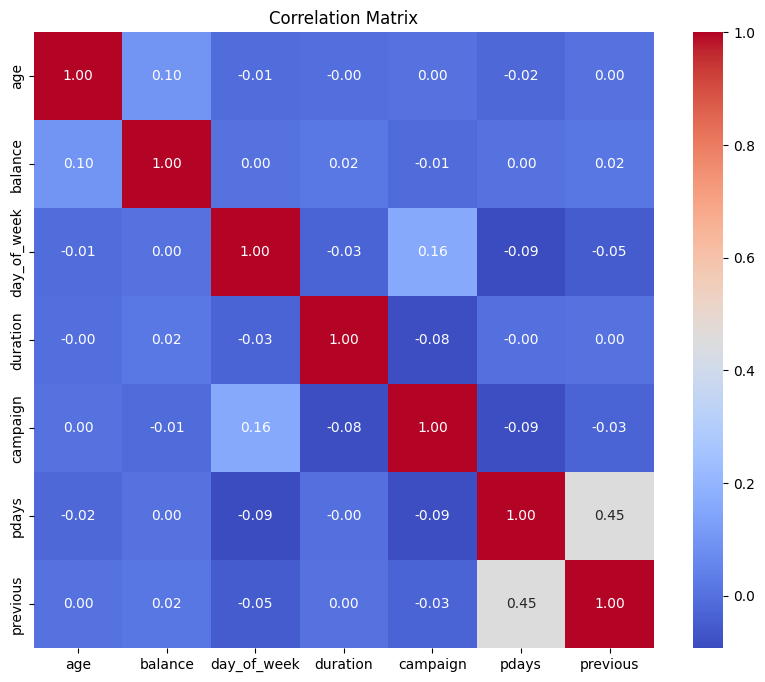

In [119]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


**Previous Contact vs Target Analysis:**  
- Biến `pdays_contacted` được tạo để phân biệt khách hàng đã từng được liên hệ trước đó và khách hàng mới.  
- Biểu đồ cho thấy sự khác biệt rõ ràng về phân bố biến mục tiêu giữa hai nhóm, trong đó nhóm khách hàng đã từng được liên hệ có số lượng đăng ký cao hơn về mặt tuyệt đối.  


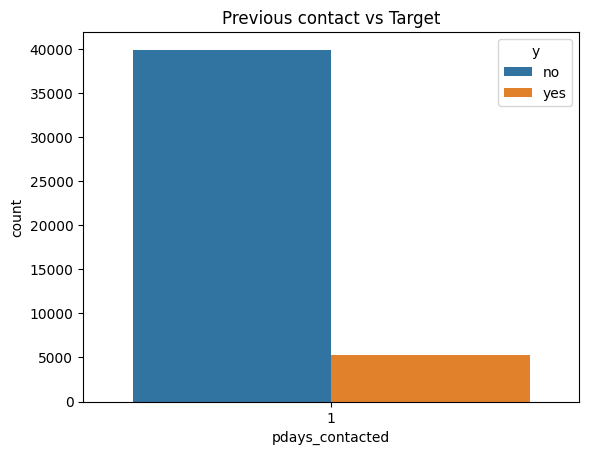

In [120]:
df["pdays_contacted"] = (df["pdays"] != 999).astype(int)

sns.countplot(x="pdays_contacted", hue="y", data=df)
plt.title("Previous contact vs Target")
plt.show()


In [128]:
df.to_csv("../data/processed/bank_marketing_raw.csv", index=False)
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y', 'poutcome_missing', 'target',
       'pdays_contacted', 'has_previous_campaign'],
      dtype='object')